<a href="https://colab.research.google.com/github/szhang12345/MSDS-422-Assignment-9-AutoEncoder/blob/main/Assignment9_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###### **MSDS 422 Assignment 9: Autoencoder**

**By Siying Zhang**

**Topic: Digit Recognizer**


# Ingest

In [204]:
from __future__ import division, print_function, unicode_literals

# import base packages into the namespace for this program
import numpy as np
import os
import pandas as pd
from pandas.plotting import scatter_matrix
from keras.callbacks import EarlyStopping
import datetime
import os.path
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Reshape, Flatten, Lambda, Conv2DTranspose,UpSampling2D
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras import layers
from keras import backend as K
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from scipy.stats import norm

K.clear_session()
from keras.layers import *
from keras.models import *
from keras.losses import *
from keras.callbacks import *
from keras.optimizers import *
from keras import backend as K
import matplotlib.pyplot as plt
from keras import metrics
from keras.datasets import mnist
from keras import optimizers
# Ensure results are reproducable
from numpy.random import seed
seed(1)
import tensorflow.compat.v1 as tf
# Reset the session
tf.disable_v2_behavior()
tf.reset_default_graph()
tf.set_random_seed(2)
np.random.seed(1)

Reading Data

In [165]:
!pip install -U -q PyDrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [166]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/mnist_train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/mnist_test.csv')

In [167]:
# Create arrays for use with sklearn
X_train = train.drop(['label'], axis=1)
y_train = train['label']
X_test = test.drop(['label'], axis=1)
y_test = test['label']


In [138]:
# Input dimensions i.e. the image size when flattened for Simple Autoencoder Model
a=X_train.values.astype(np.float32) / 255
input_dim = np.prod(a.shape[1:])
X_train_flat = X_train.values.astype(np.float32) / 255.
X_train_flat = X_train_flat.reshape((X_train_flat.shape[0], input_dim))
X_test_flat = X_test.values.astype(np.float32) / 255.
X_test_flat = X_test_flat.reshape((X_test_flat.shape[0], input_dim))


In [198]:
# Normalize and reshape for VAE model
X_train_vae = X_train.astype('float32') / 255.
X_train_vae = X_train_vae.values.reshape(-1,28,28,1)

X_test_vae = X_test.astype('float32') / 255.
X_test_vae = X_test_vae.values.reshape(-1,28,28,1)


# EDA

In [143]:
#test and train set shape for Simple Autoencoder Model
print(X_train_flat.shape)
print(y_train.shape)
print(X_test_flat.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [207]:
#test and train set shape for VAE Model
print(X_train_vae.shape)
print(y_train.shape)
print(X_test_vae.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


VAE Training Sample Visualization

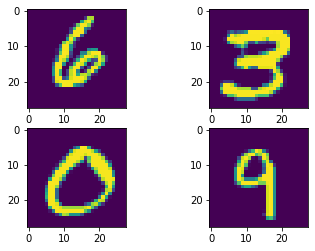

In [144]:
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train_vae[13][:,:,0])

plt.subplot(222)
plt.imshow(X_train_vae[111][:,:,0])

plt.subplot(223)
plt.imshow(X_train_vae[2325][:,:,0])

plt.subplot(224)
plt.imshow(X_train_vae[42124][:,:,0])
plt.show()

# Modeling

**Model 1 Simple Autoencoder Model**

Parameters Setting

In [145]:
# The dimensionality of the encoded representation.
encoded_dim = 32
# Sizes and number of hidden layers.
hidden_layer_weights = [392, 98]
hidden_layers = len(hidden_layer_weights)

In [146]:
# Create encoding layers.
def get_encoder(input, layers, encoded_dim, units):
    x = None
    for i in range(layers):
        x = keras.layers.Dense(units[i]
                               , activation='relu')(input if x is None else x)
    return keras.layers.Dense(encoded_dim
                              , activation='relu')(x)

# Create decoding layers.
def get_decoder(input, layers, input_dim, units):
    x = None
    for i in range(layers):
        x = keras.layers.Dense(units[i]
                               , activation='relu')(input if x is None else x)
    return keras.layers.Dense(input_dim
                              , activation='sigmoid')(x)

# Create a new stack of layers from existing layers with new input layer.
def add_new_input(input, layers):
    new_layer_stack = input
    for layer in layers:
        new_layer_stack = layer(new_layer_stack)
    return new_layer_stack

In [147]:
# Input to encoder.
input = keras.layers.Input(shape=(input_dim,))
# Create encoder half.
encoded_layer = get_encoder(input, hidden_layers, encoded_dim, hidden_layer_weights)
# Create decoder half.
decoded_layer = get_decoder(encoded_layer, hidden_layers, input_dim, list(reversed(hidden_layer_weights)))

# Assemble full autoencoder model.
full_model = keras.models.Model(input, decoded_layer)

# Assemble encoder model.
encoder = keras.models.Model(input, encoded_layer)

# Assemble decoder model (with new input!).
decoder_input = keras.layers.Input(shape=(encoded_dim,))
decoder = keras.models.Model(decoder_input, add_new_input(decoder_input, full_model.layers[-(hidden_layers + 1):]))

In [148]:
full_model.compile(optimizer=keras.optimizers.Adam()
                   , loss=keras.losses.binary_crossentropy
                   , metrics=[keras.metrics.binary_crossentropy,'accuracy'])

full_model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_14 (Dense)             (None, 392)               307720    
_________________________________________________________________
dense_15 (Dense)             (None, 98)                38514     
_________________________________________________________________
dense_16 (Dense)             (None, 32)                3168      
_________________________________________________________________
dense_17 (Dense)             (None, 98)                3234      
_________________________________________________________________
dense_18 (Dense)             (None, 392)               38808     
_________________________________________________________________
dense_19 (Dense)             (None, 784)               3081

In [152]:
# Use early stopping to stop the training when loss does not decrease anymore.
callbacks = [keras.callbacks.EarlyStopping(patience=2)]

history = full_model.fit(X_train_flat
               , X_train_flat
               , batch_size=128
               , epochs=100
               , shuffle=True
               , validation_split=.1
               , callbacks=callbacks)

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 10s 190us/sample - loss: 0.1115 - binary_crossentropy: 0.1115 - acc: 0.8116 - val_loss: 0.1050 - val_binary_crossentropy: 0.1050 - val_acc: 0.8125
Epoch 2/100
54000/54000 [==============================] - 11s 195us/sample - loss: 0.1011 - binary_crossentropy: 0.1011 - acc: 0.8129 - val_loss: 0.0983 - val_binary_crossentropy: 0.0983 - val_acc: 0.8137
Epoch 3/100
54000/54000 [==============================] - 10s 191us/sample - loss: 0.0954 - binary_crossentropy: 0.0954 - acc: 0.8135 - val_loss: 0.0938 - val_binary_crossentropy: 0.0938 - val_acc: 0.8139
Epoch 4/100
54000/54000 [==============================] - 10s 193us/sample - loss: 0.0916 - binary_crossentropy: 0.0916 - acc: 0.8139 - val_loss: 0.0906 - val_binary_crossentropy: 0.0906 - val_acc: 0.8142
Epoch 5/100
54000/54000 [==============================] - 10s 190us/sample - loss: 0.0891 - binary_crossentropy: 0.0891 - acc:

Result

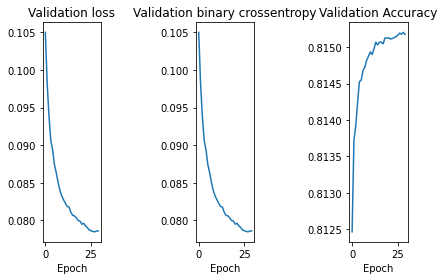

In [153]:
fig, axes = plt.subplots(1, 3)

val_loss_ax = axes[0]
val_loss_ax.plot(history.history['val_loss'])
val_loss_ax.title.set_text('Validation loss')
val_loss_ax.set_xlabel('Epoch')

val_bincross_ax = axes[1]
val_bincross_ax.plot(history.history['val_binary_crossentropy'])
val_bincross_ax.title.set_text('Validation binary crossentropy')
val_bincross_ax.set_xlabel('Epoch')

val_bincross_ax = axes[2]
val_bincross_ax.plot(history.history['val_acc'])
val_bincross_ax.title.set_text('Validation Accuracy')
val_bincross_ax.set_xlabel('Epoch')


plt.tight_layout()
plt.show()

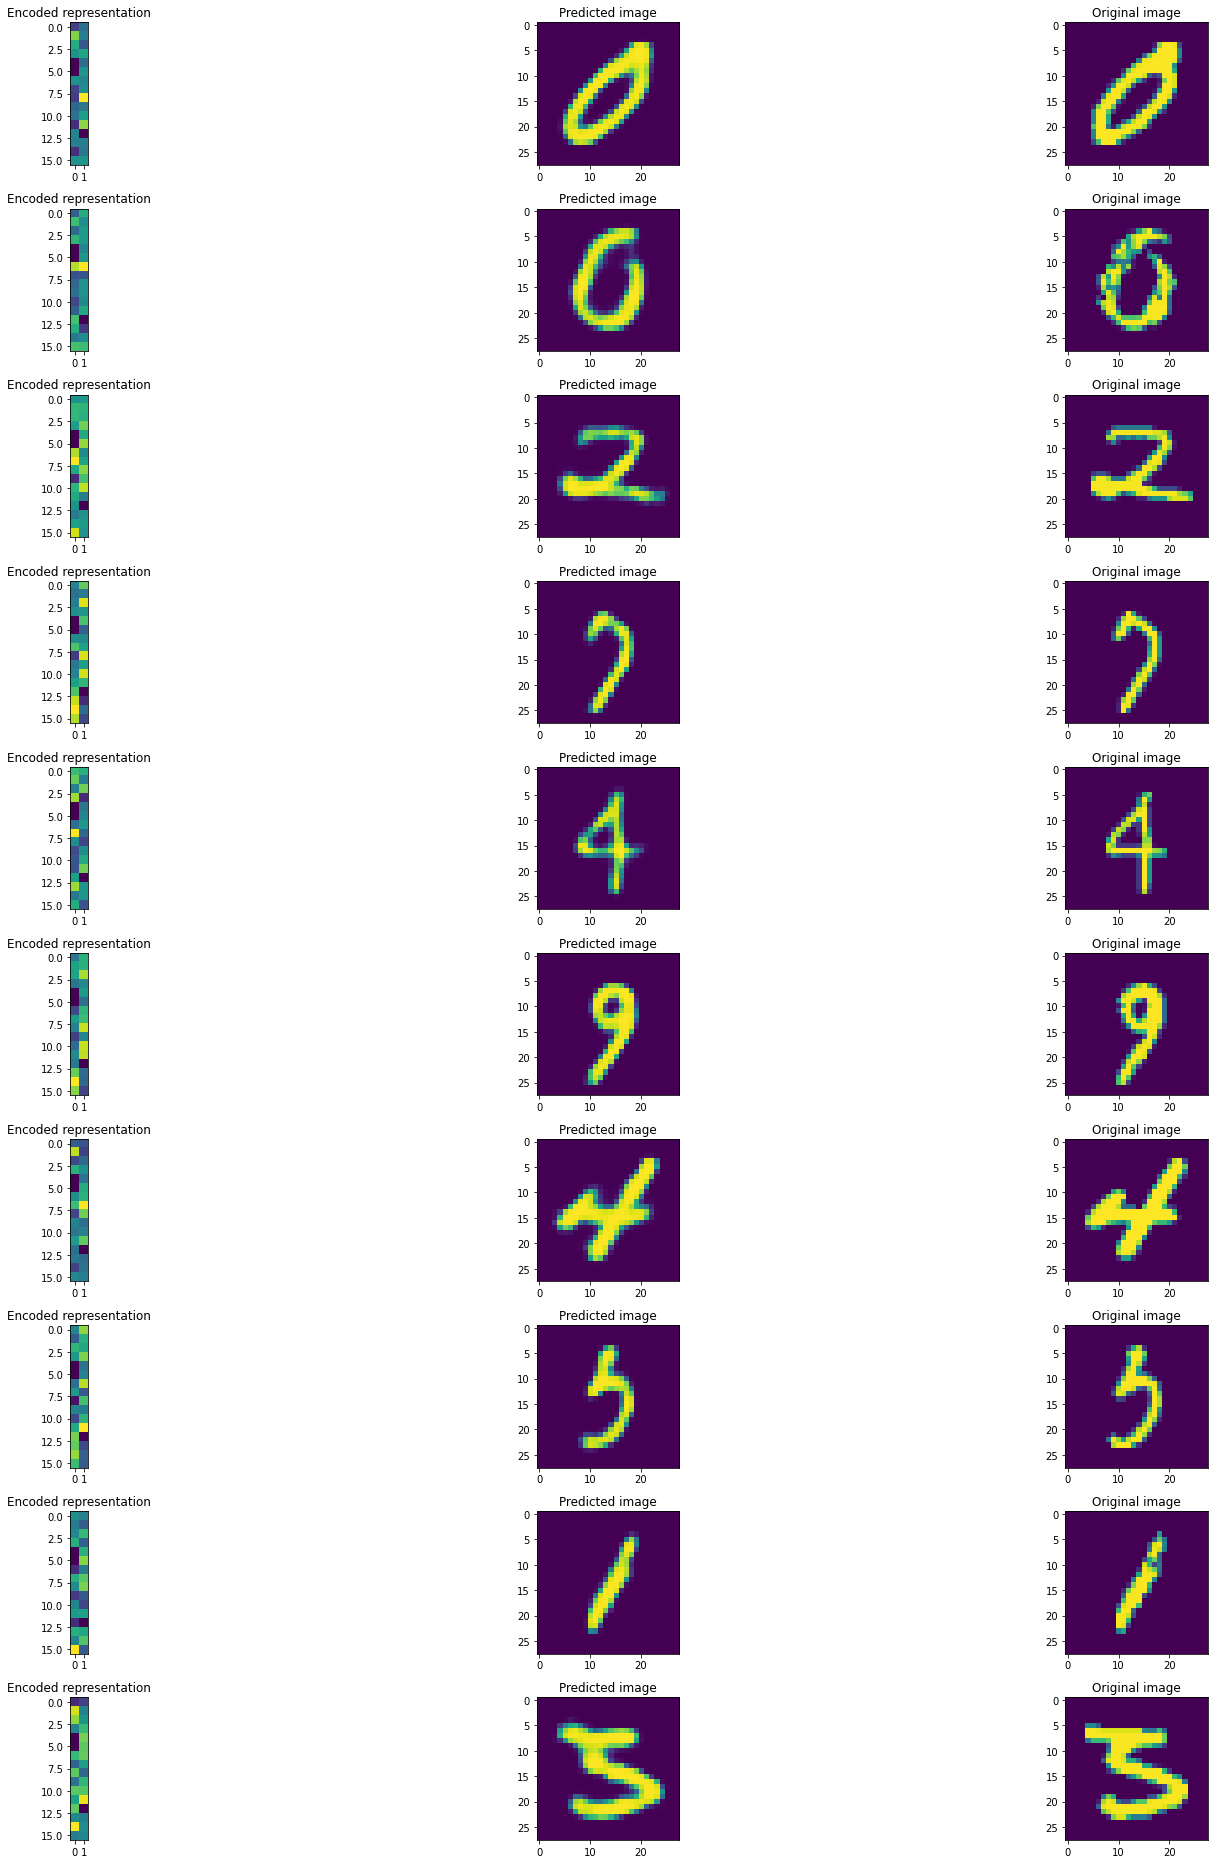

In [154]:
# Visualize X examples.
num_visualizations = 10
visualization_start_index = np.random.randint(0, len(X_test_flat))

# Shuffle test images.
np.random.shuffle(X_test_flat)

fig, axes = plt.subplots(1 * num_visualizations, 3)

for i in range(num_visualizations):
    test_index = visualization_start_index + i
    x_encoded = encoder.predict(X_test_flat[test_index].reshape(1, -1))
    x_predicted = decoder.predict(x_encoded)    
    encoded_columns = 2
    
    # Plot the encoded representation.
    ax_encoded = axes[i][0]
    ax_encoded.imshow(x_encoded.reshape((encoded_dim // encoded_columns, encoded_columns)))
    ax_encoded.title.set_text('Encoded representation')
    # Plot the predicted digit.
    ax_predicted = axes[i][1]
    ax_predicted.imshow(x_predicted.reshape((28, 28)))
    ax_predicted.title.set_text('Predicted image')
    # Plot the actual image.
    ax_original = axes[i][2]
    ax_original.imshow(X_test_flat[test_index].reshape((28, 28)))
    ax_original.title.set_text('Original image')

fig.set_size_inches(26, 26)
plt.tight_layout()
plt.show()

**Model 2 Variational Autoencoders (VAE) model**

A. Encoder network

In [221]:
img_shape = (28, 28, 1)    # for MNIST
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', 
                  activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = layers.Dense(latent_dim)(x)
z_log_sigma = layers.Dense(latent_dim)(x)

B. Sampling function

In [222]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = layers.Lambda(sampling)([z_mu, z_log_sigma])

C. Decoder network

In [223]:
# decoder takes the latent distribution sample as input
decoder_input = layers.Input(K.int_shape(z)[1:])

# Expand to 784 total pixels
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# reshape
x = layers.Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = layers.Conv2DTranspose(32, 3,
                           padding='same', 
                           activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', 
                  activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

D. Loss

In [224]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])


In [227]:
# instantiate VAE model
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None,metrics=['accuracy'])
vae.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 28, 28, 32)   320         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 14, 14, 64)   18496       conv2d_33[0][0]                  
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 14, 14, 64)   36928       conv2d_34[0][0]                  
____________________________________________________________________________________________

In [228]:
vae.fit(x=X_train_vae, y=None,
        shuffle=True,
        epochs=5,
        batch_size=batch_size,
        validation_data=(X_test_vae, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - ETA: 0s - loss: 0.1998

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


60000/60000 [==============================] - 388s 6ms/sample - loss: 0.1998 - val_loss: 0.1934
Epoch 2/5
60000/60000 [==============================] - 412s 7ms/sample - loss: 0.1917 - val_loss: 0.1885
Epoch 3/5
60000/60000 [==============================] - 393s 7ms/sample - loss: 0.1884 - val_loss: 0.1861
Epoch 4/5
60000/60000 [==============================] - 383s 6ms/sample - loss: 0.1862 - val_loss: 0.1849
Epoch 5/5
60000/60000 [==============================] - 387s 6ms/sample - loss: 0.1848 - val_loss: 0.1873


Result
A. Clustering of digits in the latent space

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


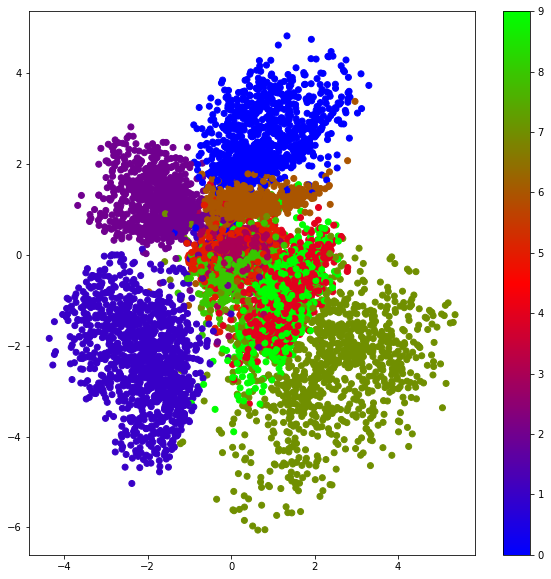

In [230]:
# Translate into the latent space
encoder = Model(input_img, z_mu)
x_test_encoded = encoder.predict(X_test_vae, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='brg')
plt.colorbar()
plt.show()

Result B. Sample digits

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


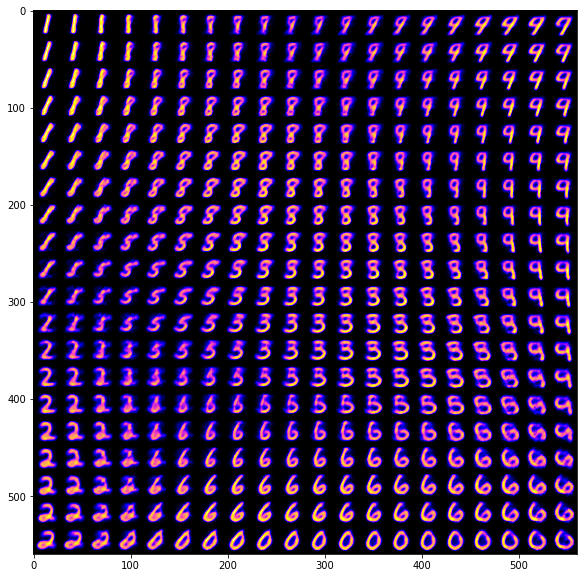

In [232]:
# Display a 2D manifold of the digits
n = 20  # figure with 20x20 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gnuplot2')
plt.show()  

# Conclusion

# Background and management problem description

Continue work on the Digit Recognition problem using autoencoder neural network models and analyze the performance of autoencoder models on MNIST dataset.

# Research design and modeling methods
1. Import and preprocess data
2. Set parameters and define autoencoder backpropagation function
3. Run a process to train autoencoder
4. Visualise what the autoencoder has learned
5. Analyze the performance

# Results and Recommendations
Two autoencoder models are used in this assignment, first is a simple autoencoder model and the second is variational autoencoder model.

Based on the performances, it appears that using the simple autoencoder model, the validation accuracy increased from 0.8125 to 0.8151, and the loss decreased from 0.1050 to 0.0786.

From the result of VAE model, it doesn't appear that the validation loss decreased significantly through 5 epochs, and the processing time of VAE model is much higher than simple autoencoder model. However, the image generated above shows that distinct digits each exist in different regions of the latent space and smoothly transform from one digit to another. This smooth transformation can be quite useful when you'd like to interpolate between two observations. It also tackles the problem of the latent space irregularity by making the encoder return a distribution over the latent space instead of a single point and by adding in the loss function a regularisation term over that returned distribution in order to ensure a better organisation of the latent space and avoid overfitting.
